<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Upload-Dicom-Image" data-toc-modified-id="Upload-Dicom-Image-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Upload Dicom Image</a></span></li><li><span><a href="#Preprocess-Image" data-toc-modified-id="Preprocess-Image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocess Image</a></span></li><li><span><a href="#Make-a-prdiction-on-each-cube" data-toc-modified-id="Make-a-prdiction-on-each-cube-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make a prdiction on each cube</a></span></li><li><span><a href="#Concatenate-cubes" data-toc-modified-id="Concatenate-cubes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Concatenate cubes</a></span></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import random
import os
from imports import *
import mxnet as mx

# Upload Dicom Image

In [4]:
#file = '/media/mas/Untitled/LIDC/DOI/LIDC-IDRI-0005/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225/'

# Preprocess Image

In [5]:
scan_id =54
scan_1 = ctscan(scan_id) 

Loading dicom files ... This may take a moment.


In [44]:
Vol0=scan_1.image_normalized #zxy

In [7]:
K,I,J=Vol0.shape
print(I,J,K)

380 380 282


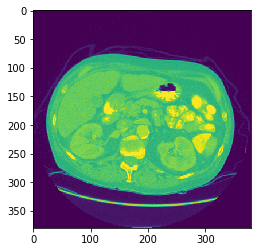

In [8]:
Vol1=[]

for k in range(0,K,32):
    for i in range(0,I,32):
        for j in range(0,J,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

plt.imshow(Vol0[0,:,:])

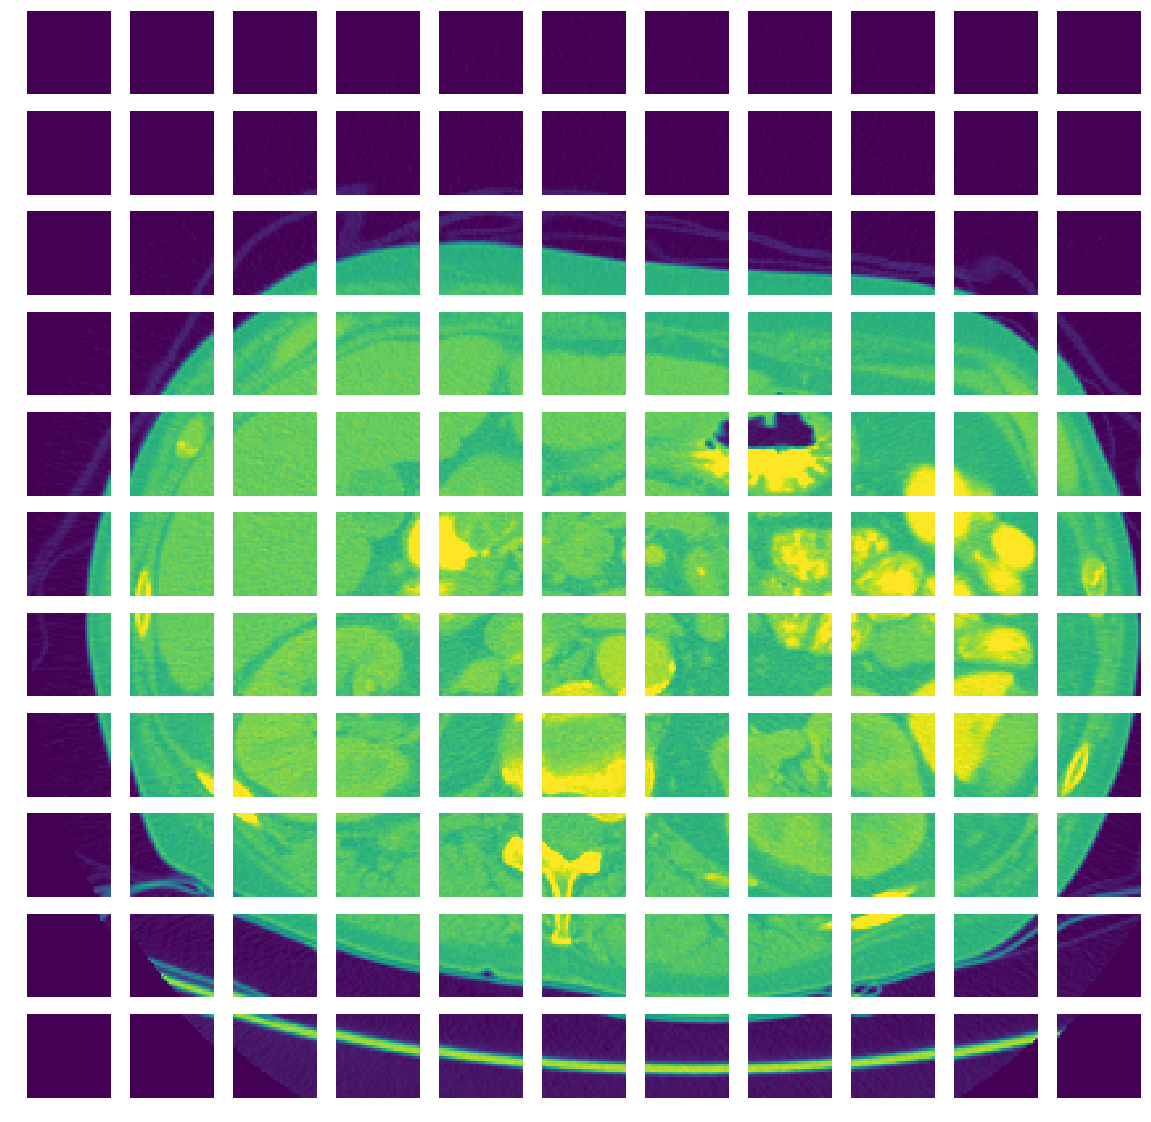

In [9]:
img=Vol1 #nxyz
f, plots = plt.subplots(11, 11, sharex='col', sharey='row', figsize=(20, 20))

for i in range(12*12):
    num=i
    if np.array(img[num]).shape ==(32,32,32):
        plots[i // 12, i % 12].axis('off')
        plots[i // 12, i % 12].imshow(img[num][0,:,:],interpolation='none',vmin=Vol0[num].min(),vmax=Vol0[num].max())

#check visualize-Copy4working+model-Copy3.ipynb

In [10]:
len(Vol1),Vol1[-1].shape

(1296, (26, 28, 28))

In [11]:
X_train = Vol1.copy()

380 380 282


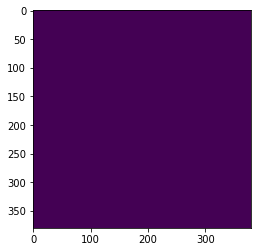

In [12]:
Vol0=scan_1.Z2 #zxy
K,I,J=Vol0.shape
print(I,J,K)
Vol1=[]

for k in range(0,K,32):
    for i in range(0,I,32):
        for j in range(0,J,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

plt.imshow(Vol0[0,:,:])

In [13]:
Y_train = Vol1.copy()

In [14]:
X_train2 = [j for j in X_train if j.shape==(32,32,32)]

X_train2 = [ np.expand_dims(e, axis=0) for e in X_train2]

X_train3 = np.array(X_train2)

mean_image =.27
std_image = .27

X_train4= X_train3 - mean_image
X_train4 = X_train4/std_image
X_train4.shape

(968, 1, 32, 32, 32)

In [15]:
Y_train2 = [j.reshape((32*32*32)) for j in Y_train if j.shape==(32,32,32)]

#Y_train2 = [ np.expand_dims(e, axis=0) for e in Y_train2]
#Y_train2[-1].shape

Y_train3 = np.array(Y_train2)

Y_train3.shape


(968, 32768)

# Make a prdiction on each cube

In [16]:
model_path = "/home/mas/x110/model/oct31"
model_epoch=400

In [17]:
bs=34
train_iter = mx.io.NDArrayIter(X_train4, Y_train3, batch_size=bs)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)

input_shapes {'softmax_label': (34, 32768), 'data': (34, 1, 32, 32, 32)}


In [18]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]


exe.copy_params_from(arg_params, aux_params)

In [19]:
def get_sample_at(valid_iter,n):
    valid_iter.ind2=[n]
    return valid_iter.next()

index = 893


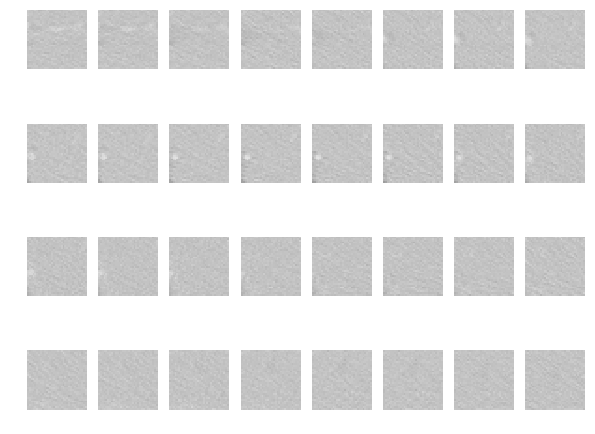

In [25]:
K = train_iter.num_data
n = random.randint(0,K)
print('index = '+ str(n))
batch = get_sample_at(train_iter,n)

#batch = train_iter.next()
data[:] = batch.data[0]       
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)
p = outputs[0][0].asnumpy().reshape(32,32,32)
msk2 = p>.5#.001
msk2=msk2*1
msk2= np.ma.masked_where(msk2 == 0, msk2)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*std_image+mean_image
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none',  alpha=0.4, vmin=0, vmax=1)


      

# Concatenate cubes

In [28]:
ind = [i for i,j in enumerate(X_train) if j.shape==(32,32,32)]
ind[0:5]

[0, 1, 2, 3, 4]

In [37]:
X_train5=X_train.copy()

In [38]:
for a,b in zip(ind,X_train4):
    X_train5[a]=b[0]

In [39]:
X_train5[0].shape

(32, 32, 32)

In [46]:
Vol1=X_train.copy()

In [47]:
A=np.zeros((Vol0.shape))
m=0

for k in range(0,K,32):
    for i in range(0,I,32):
        for j in range(0,J,32):
            z,x,y=np.array(Vol1[m]).shape
            A[k:k+z,i:i+x,j:j+y]=Vol1[m]
            m=m+1

IndexError: list index out of range

In [48]:
m

1296

In [12]:
plt.imshow(A[0,:,:])

In [13]:
A.shape

(375, 374, 374)

In [14]:
np.array(A).shape

(375, 374, 374)

# Visualize

TypeError: Invalid dimensions for image data

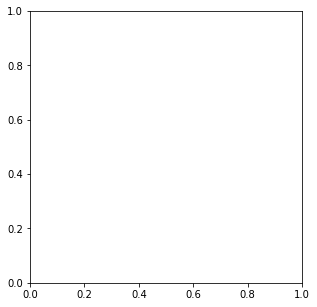

In [32]:
image3d=np.array(A)#scan_1.image_resampled
Y = scan_1.Z2
Y= np.ma.masked_where(Y == 0, Y)
fig = plt.figure(figsize=(5,5)) # make figure
ax = plt.subplot(1,1,1)
im = plt.imshow(image3d[0],'gray',vmin=0,vmax=1)
im2 = plt.imshow(Y[0],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)


ztot=5
rects=[patches.Rectangle((512,512),1,1,linewidth=1,edgecolor='r',facecolor='none') for i in range(ztot)]




for r in rects:
    ax.add_patch(r)



# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(image3d[j])
    im2.set_array(Y[j])



    for i in range(ztot):
        if i <len(scan_1.Zbbox[j]):
            rects[i].set_xy(scan_1.Zbbox[j][i][0:2])
            rects[i].set_height(scan_1.Zbbox[j][i][2])
            rects[i].set_width(scan_1.Zbbox[j][i][3])
        else:
            rects[i].set_xy([512,512])


    ax.set_title("Slice"+str(j))
    return im,im2,rects

# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(len(image3d)),
                              interval=50, blit=True)
#ani.save('Chest_Cavity5.gif', writer='imagemagick')